In [8]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, sin, pi, linalg
import timeit
import matplotlib.cm as cm

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# Simulação Numérica


In [10]:
# parâmetros
L = 1
T = 5
k = 0.01
h = 0.002
gamma1 = k/(4*h)
gamma2 = k/(2*h**2)

# Malha
x = np.arange(0,L+h,h)   #dessa forma, adaptando os steps, dá pra definir qualquer intervalo em x
x0 = (min(x) + max(x))/2
t = np.arange(0,T+k,k)
'''incorporei essa constante posteriormente para definir o ponto médio do espaço
sem x0, sempre que o intervalo do espaço muda, não necessariamente o coef. "enxerga" onde a difusão será
#maxima e igual a D0.'''
n = len(x)
m = len(t)
#[m,n]


Vamos fazer a simulação da solução numérica da equação

\begin{eqnarray}
\partial _t \rho &=& \partial_x (D(x,t) \partial _x \rho) + f(x,t,\rho) \\
\rho(0,t) &=& \rho(L,t) = 0 \\
\rho(x,0) &=& \frac{N_0}{L}
\end{eqnarray}

com $(x,t) \in [0,L] \times \mathbb{R}_+$, $L>0$, e $N_0$ correspondendo ao tamanho inicial da população.

A ideia é fazer a simulação para diferentes valores da função fonte $f(x,t,\rho)$:

\begin{eqnarray}
f_m &=& r(t)\rho(x,t) \ \ \ \text{(fonte malthusiana)} \\
f_{c} &=& r(t)\rho ^2(x,t) \ \ \ \text{(fonte facilitada)} \\
f_l &=& r(t)\rho(x,t) \left(1 - \frac{\rho(x,t)}{K(t)}\right) \ \ \ \text{(fonte logística)}.
\end{eqnarray}

### Difusão variável com crecimento logístico

A discretização da EDP com o método de Crank-Nilson fica

\begin{eqnarray}
 (-\gamma_1 E ^{j+1/2}_{i} - \gamma_2 D^{j+1/2}_{i}) \rho^{j+1}_{i+1} + (1 + 2 \gamma_2 D^{j+1/2}_{i}) \rho^{j+1}_{i} + (\gamma_1 E ^{j+1/2}_{i} - \gamma_2 D^{j+1/2}_{i}) \rho^{j+1}_{i-1} = (\gamma_1 E ^{j+1/2}_{i} + \gamma_2 D^{j+1/2}_{i})\rho^{j}_{i+1} +(r^{j+1/2}- 2 \gamma_2 D^{j+1/2}_{i}) \rho^{j}_{i} + (-\gamma_1 E ^{j+1/2}_{i} + \gamma_2 D^{j+1/2}_{i}) \rho^{j}_{i-1} + k\ r^{j+1/2}_{i}\rho^{j}_{i} \left( 1 - \frac{ \rho^{j} _{i} }{ K^{j+1/2}_{i}} \right).
\end{eqnarray}

 com $h=\Delta x$, $k=\Delta t$, $\gamma_1 = k / 4h$ e $\gamma_2 = k / 2h^2$.

 A forma matricial da solução fica

 $$
 A \rho^{j+1} = B  \rho^{j} + F(\rho^j).
 $$



#### Funções auxiliares

In [12]:
#funções auxiliares

#suporte
k1 = 20
k2 = 0.5*k1
pk = T/0.5
K = k1 + k2*sin(2*pi*t/pk)

#tx crescimento
r1 = 1.5
r2 = 0.1*k1
pr = T/5.5  #periodo oscilação crescimento
r = r1 + r2*sin(2*pi*t/pr) + k/2

# Difusividade D(x,t) e sua derivada Dx
D0 = 1.5
D = np.zeros((n,m))
Dx = np.zeros((n,m))
for i in range(n):
  for j in range(m):
      D[i,j] = D0 * (exp(-K[j]*(x0 - x[i])**2 )) + k/2 #difusao
      Dx[i,j] = (-2)*(K[j])*(-x0 + x[i])* D[i,j] + k/2

In [13]:
# Condições Iniciais e de Contorno
boudaryconditions = [0, 0]
N0 = 10
inicialconditions = N0/L#*sin(pi*x).round(3)

rhol = np.zeros((n,m))
rhol[0,:] = boudaryconditions[0]  # rho(0, t)
rhol[-1,:] = boudaryconditions[1] # rho(L, t)
rhol[:,0] = inicialconditions     #rho(x,0)

$$A \rho^{j+1} = B  \rho^{j} + F(\rho^j).$$

In [14]:
#Construção das matrizes tridiagonais
A = np.zeros((n,m))
for i in range(n):
  #A = A + np.diag([1+2*gamma2*D[i,i]],0)
    A[i,i] = 1+2*gamma2*D[i,i]   #diag. principal
    if i < n-1:
      A[i,i+1] = -gamma1*Dx[i,i+1] - gamma2*D[i,i+1]      #diag. upper
      A[i+1,i] = gamma1*Dx[i+1,i] - gamma2*D[i+1,i]      #diag. lower


B = np.zeros((n,m))
for i in range(n):
  #A = A + np.diag([1+2*gamma2*D[i,i]],0)
    B[i,i] = 1-2*gamma2*D[i,i]   #diag. principal
    if i < n-1:
      B[i,i+1] = gamma1*Dx[i,i+1] + gamma2*D[i,i+1]      #diag. upper
      B[i+1,i] = -gamma1*Dx[i+1,i] + gamma2*D[i+1,i]      #diag. lower
      #print(r[i],-2*gamma2*D[i,i])


In [15]:
# Resolver o sistema linear
for j in range(0, m-1):
  b = rhol[:,j].copy()
  Logi = rhol[:,j].copy()* k*r[j] - rhol[:,j].copy()**2 * k*r[j]/K[j]
  b = np.dot(B,b) + Logi
  b[0] = boudaryconditions[0]
  b[-1] = boudaryconditions[-1]
  solution = linalg.solve(A,b)
  rhol[:,j+1] = solution


#### Gráfico

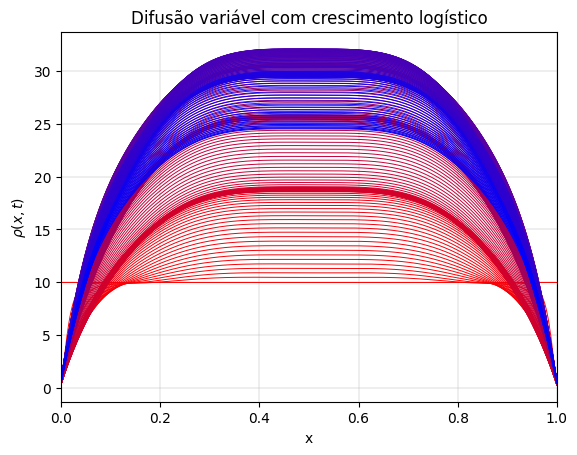

In [16]:
M = 500
colors = [(1 - i/M, 0, i/M) for i in range(M)]

for j in range(0, M, max(1, int(M/250))):
  plt.plot(x, rhol[:,j], linewidth=0.7, color=colors[j])

#interact(plt.plot(x, rhol[:,T]), T=200)
plt.title('Difusão variável com crescimento logístico')
plt.xlabel('x')
plt.ylabel('$\\rho(x,t)$')
plt.xlim(0,1)
#plt.ylim(7,9)
#plt.legend([f't = {value.round(3)}' for value in t])
plt.grid(linestyle='-', linewidth=0.3)

plt.savefig('difusao-_variavel_crescimento_logistico')
plt.show()
#print(f"Do tempo t={t[0]} até t={t[M].round(3)}.")



Como é um modelo de crescimento controlado o que ocorre? kkkkk crescimento controlado, nesse caso, em boa
partes das vezes pela densidade inicial (por que?). Observa-se que, para densidades maiores que 1, quanto
maior a taxa de crescimento, mais rápido a densidade decresce, porém de forma "estabilizada" ou paralela
a densidade inicial, próximo ao ponto médio do espaço.

Os parametros da capacidade suporte, até então, interferem em como a densidade "samba" ao longo do tempo,
fazendo com que intervalos do espaço sejam mais densos que outros.

Para densidade inferior a 1, (ex. N0=0.5) pode ocorre crescimento em espaços próximos ponto médio do espaço. Nesse caso,
a capacidade suporte influencia no crescimento em locais específicos do espaço (ainda não entendi o porque fica
mais denso no lado direito!), exemplo, para k1=5. Taxa de crescimento, obviamente contribui para o o aumento. Nesse
caso, suporte alto + taxa crescimento alta provocam um comportamento semelhante ao do crescimento malthusiano.

In [7]:
#def f(T):
#  M = 500
#  colors = [(1 - i/M, 0, i/M) for i in range(M)]
#  for j in range(0, M, max(1, int(M/400))):
#    plt.plot(x, rhol[:,j], linewidth=0.7, color=colors[j]);

#  return plt.plot(x, rhol[:,T], linewidth=2, color="black", linestyle='--')

#interact(f, T=200);